This notebook implements a supervised generative classifier for binary MNIST data using class-conditional Bernoulli distributions

In [2]:
%matplotlib inline
# %matplotlib notebook
%config Completer.use_jedi = False
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import logsumexp
from scipy.special import softmax
import numpy.linalg as linalg
from sklearn.cluster import KMeans
from sklearn import metrics
import scipy.sparse as sparse

from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [3]:
random_seed = 123
rng = np.random.default_rng(random_seed)

# 1 Import Dataset

In [4]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', parser ='auto')

Binarize Data

In [5]:
X_mnist = np.array(mnist.data) > 0.5 # binary-rise the data
Y_mnist = np.array(mnist.target, dtype ='int')
X_mnist_train = X_mnist[:4000, :] # use the first 4000 images as training data
Y_mnist_train = Y_mnist[:4000]
X_mnist_test = X_mnist[4000:5000, :] # the next 1000 as testing
Y_mnist_test = Y_mnist[4000:5000]

# 2  Algorithm

Assume shared covariance $\Sigma$

$$\begin{align}
    \hat{\pi}_c &= \frac{n_c}{n}\\
    \hat{\mu}_c  &= \frac{1}{n_c}\sum_{i=1}^{n} \mathbb{1}(y^{(i)} = c) \cdot \mathbf{x}^{(i)}\\
    \hat{\Sigma} &= \frac{1}{n}\sum_{c=i}^{C}\sum_{i=1}^{n} \mathbb{1}(y^{(i)} = c)(\mathbf{x}^{(i)} - \mu_c)(\mathbf{x}^{(i)} - \mu_c)^\top
\end{align}$$

In [6]:
def fit(X, y):
    ''' 
        X : input matrix (n x d)
        y : labels 
    '''

    n,d = X.shape
    sse = np.zeros((d,d))
    K = len(set(y))
    mus = np.zeros((K,d))
    pis = np.zeros(K)
    
    for c in set(y):
        pis[c] = sum(1 for x in y if x == c)

        # mus[c] = np.mean([x for x,i in enumerate(X) if y[i] == c])
        Xc = X[y==c]
        mus[c] = np.mean(Xc, axis=0)

        error = Xc - mus[c]

        sse += np.dot(error.T, error)

    return pis/n, mus, sse/n


Log Likelihood:
$$\begin{align}
    \hat{y} &=  \argmax_k \left \{ \ln\pi_k \cdot p(\mathbf{x}^{(i)}| \boldsymbol{\mu}_k)\right \}\\

    &= \argmax_k \left \{ \ln\pi_k + \sum_{d=1}^D x_d^{(i)} \ln\mu_{kd} + (1-x_d^{(i)}) \ln(1-\mu_{kd}) + C \right \}
\end{align}$$

In [7]:
def predict(X, πs, μs, sse, eps=1e-14):
    n,d = X.shape
    K = len(πs)

    # Stores likelihoods of x for each cluster 
    R = np.zeros((n,K))

    for i in range(0,n):
        comp1 = np.dot(X[i], np.log(μs + eps).T)
        comp2 = np.dot(1 - X[i], np.log(1 - μs + eps).T)
        sum = np.log(πs + eps) + comp1 + comp2

        R[i] = sum

    # Compute the norm for each observation 
    log_R_norm = logsumexp(R, axis=1, keepdims=True)

    # Normalize R to sum to 1 across the clusters for each observation 
    R = np.exp(R - log_R_norm)

    zs = np.argmax(R, axis=1)

    return zs
    

## 3 Predict and Evaluate

Get fitted (learned) $\pi$ , $\mu$, and $\Sigma$ (not applicable in this case for Bernoulli)

In [9]:
pis, mus, sse = fit(X_mnist_train, Y_mnist_train)

In [10]:
print(X_mnist_train.shape)
print(Y_mnist_train.shape)

(4000, 784)
(4000,)


Plot the learned cluster centers

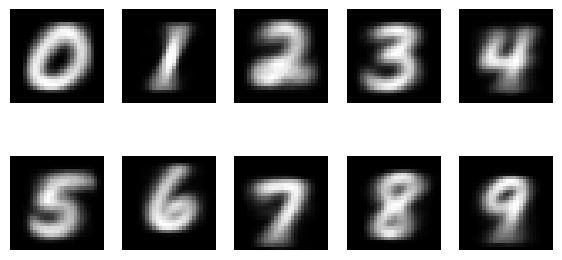

In [58]:
figure = plt.figure(figsize=(7, 3.5))
rows, cols= 2, 5
for k in range(10):
    img = mus[k, :].reshape(28, 28)
    figure.add_subplot(rows, cols, k+1)
    # plt.title(k)
    plt.axis("off")
    plt.imshow(img, cmap="gray")
plt.show()

Get cluster assignments based on likelihood

In [60]:
zs = predict(X_mnist_test, pis, mus, sse)

In [61]:
accuracy = accuracy_score(zs, Y_mnist_test)

In [62]:
print("Accuracy :", accuracy)

Accuracy : 0.819
